In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
df_fake=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
df_true=pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

In [3]:
df_true['label']=True
df_fake['label']=False

In [4]:
df=pd.concat([df_true,df_fake],ignore_index=True)

In [5]:
df.describe()

,title,text,subject,date,label
count,44898,44898,44898,44898,44898
unique,38729,38646,8,2397,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",False
freq,14,627,11272,182,23481


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.4+ MB


In [7]:
def mapper(x):
    if x==True:
        return 1
    if x==False:
        return 0
    
encode=lambda x:mapper(x) 

In [8]:
df.label=df.label.apply(encode)

In [9]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


**We will use glove embeddings from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.**

In [10]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [11]:
df['vector']=df['text'].apply(lambda x:nlp(x).vector)

In [12]:
df.vector.values[0].shape

(300,)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label,
    test_size=0.2,
    random_state=2022
)

In [14]:
X_train.shape

(35918,)

In [15]:
X_train

array([array([-3.53193544e-02,  1.36796594e-01,  3.64496224e-02,  2.83106696e-02,
               7.06997290e-02, -5.03002368e-02, -1.77855976e-02, -8.10981318e-02,
              -4.84237298e-02,  1.98583651e+00, -1.60409465e-01,  5.33684939e-02,
               5.02746329e-02, -1.01756841e-01, -1.56066686e-01, -8.35074559e-02,
              -6.37868643e-02,  7.28111625e-01,  1.66030182e-03, -2.64690332e-02,
               2.69949976e-02, -4.56162170e-02, -2.28282399e-02, -3.36700417e-02,
               7.88509101e-02, -6.55910606e-03, -1.13446556e-01,  7.51964841e-03,
               5.52228875e-02,  1.98766403e-02,  4.13079793e-03,  1.60082560e-02,
              -3.05067804e-02,  3.78654748e-02,  5.26590087e-02, -5.87420203e-02,
              -8.69193897e-02, -2.42259521e-02, -4.42643985e-02, -6.34236336e-02,
               7.94766769e-02,  5.80006875e-02,  1.33600622e-01, -1.05153382e-01,
              -4.85943928e-02, -1.58625562e-03, -6.75483271e-02, -5.44873299e-03,
               2

In [16]:
# ValueError: setting an array element with a sequence.
# this error will be raised if the vectors are not stacked
np.stack(X_train).shape

(35918, 300)

In [17]:
X_train_2d=np.stack(X_train)
# now the weights are in the columns instead of being vertically in the form of a vector
X_test_2d=np.stack(X_test)

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
# probalistic methods take positive values only
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

In [19]:
y_pred=clf.predict(scaled_test_embed)

In [20]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4774
           1       0.90      0.80      0.85      4206

    accuracy                           0.87      8980
   macro avg       0.87      0.86      0.86      8980
weighted avg       0.87      0.87      0.87      8980



Text(33.0, 0.5, 'Truth')

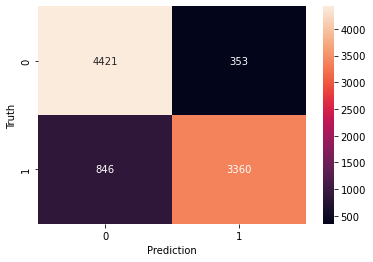

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# create a confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [22]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=7,metric='minkowski')
clf1.fit(X_train_2d,y_train)

KNeighborsClassifier(n_neighbors=7)

In [23]:
y_pred=clf1.predict(X_test_2d)

Text(33.0, 0.5, 'Truth')

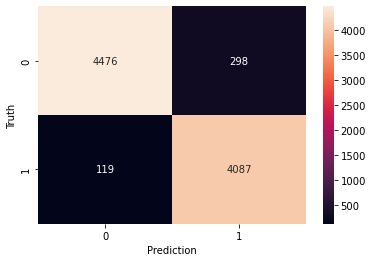

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
# create a confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [25]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4774
           1       0.93      0.97      0.95      4206

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



##### KNN model which didn't perform well in the vectorization techniques like Bag of words, and TF-IDF due to very high dimensional vector space, performed really well with glove vectors due to only 300-dimensional vectors and very good embeddings(similar and related words have almost similar embeddings) for the given text data.

##### MultinomialNB model performed decently well but did not come into the top list because in the 300-dimensional vectors we also have the negative values present. The Naive Bayes model does not fit the data if there are negative values. So, to overcome this shortcoming, we have used the Min-Max scaler to bring down all the values between 0 to 1. In this process, there will be a possibility of variance and information loss among the data. But anyhow we got a decent recall and f1 scores.